# Домашнее задание 4

В последнем практическом задании мы потренируемся в построении VaR- и ES-кривой для небольшого портфеля. Каждый актив (акцию или валюту) далее будем называть инструментом.

### 1) Загрузка данных (бесценно)

* Представьте, что вы инвестор и собираете инвестиционный портфель. 

* Загрузите данные по трём любым акциям и двум любым валютам за последние 10 лет. Акции и валюты выберите на ваш вкус, но интереснее будет взять что-то кроме евро/доллара/акций гугла.

* Можно использовать YachooFinance либо другие источники при желании.

* Переведите цены в доходности. Можно использовать разности или процентные изменения на выбор.



In [310]:
# !pip install yfinance
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
# !pip install arch
from arch import arch_model
import scipy.stats as ss
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.graphics.gofplots
import warnings
warnings.filterwarnings("ignore")

Выбрала акции букинга, ebay и Adobe Systems, а также валюту: турецкая лира/доллар и фунт стерлингов/доллар.

In [311]:
tickers = ['BKNG', 'EBAY', 'ADBE', 'TRYUSD=X', 'GBPUSD=X']
prices = yf.download(
    tickers=tickers,
    start='2014-05-19',
    end='2024-05-19',
)
prices = prices['Adj Close']
returns = prices.pct_change().dropna()
returns.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,ADBE,BKNG,EBAY,GBPUSD=X,TRYUSD=X
Date,,,,,
2014-05-20,-0.007878,-0.007344,-0.007070,-0.000437,0.000678
2014-05-21,0.012316,0.023612,-0.001540,0.001212,-0.007842
2014-05-22,0.010885,0.000527,-0.007325,0.003548,0.008892
2014-05-23,0.018211,0.016179,0.010097,-0.001754,0.005612
2014-05-26,0.000000,0.000000,0.000000,-0.001970,0.000938


### 2. Визуализация.

#### 2.1 (0.5 балла)
Изобразите парные диаграммы рассеяния (scatterplot) для всех комбинаций инструментов. В каких парах наблюдается связь, а в каких нет? Кратко интерпретируйте зависимость по одному примеру из предыдущего вопроса (один где есть зависимость, другой где нет). Если во всех парах есть зависимость (или во всех нет), то достаточно одного примера. 

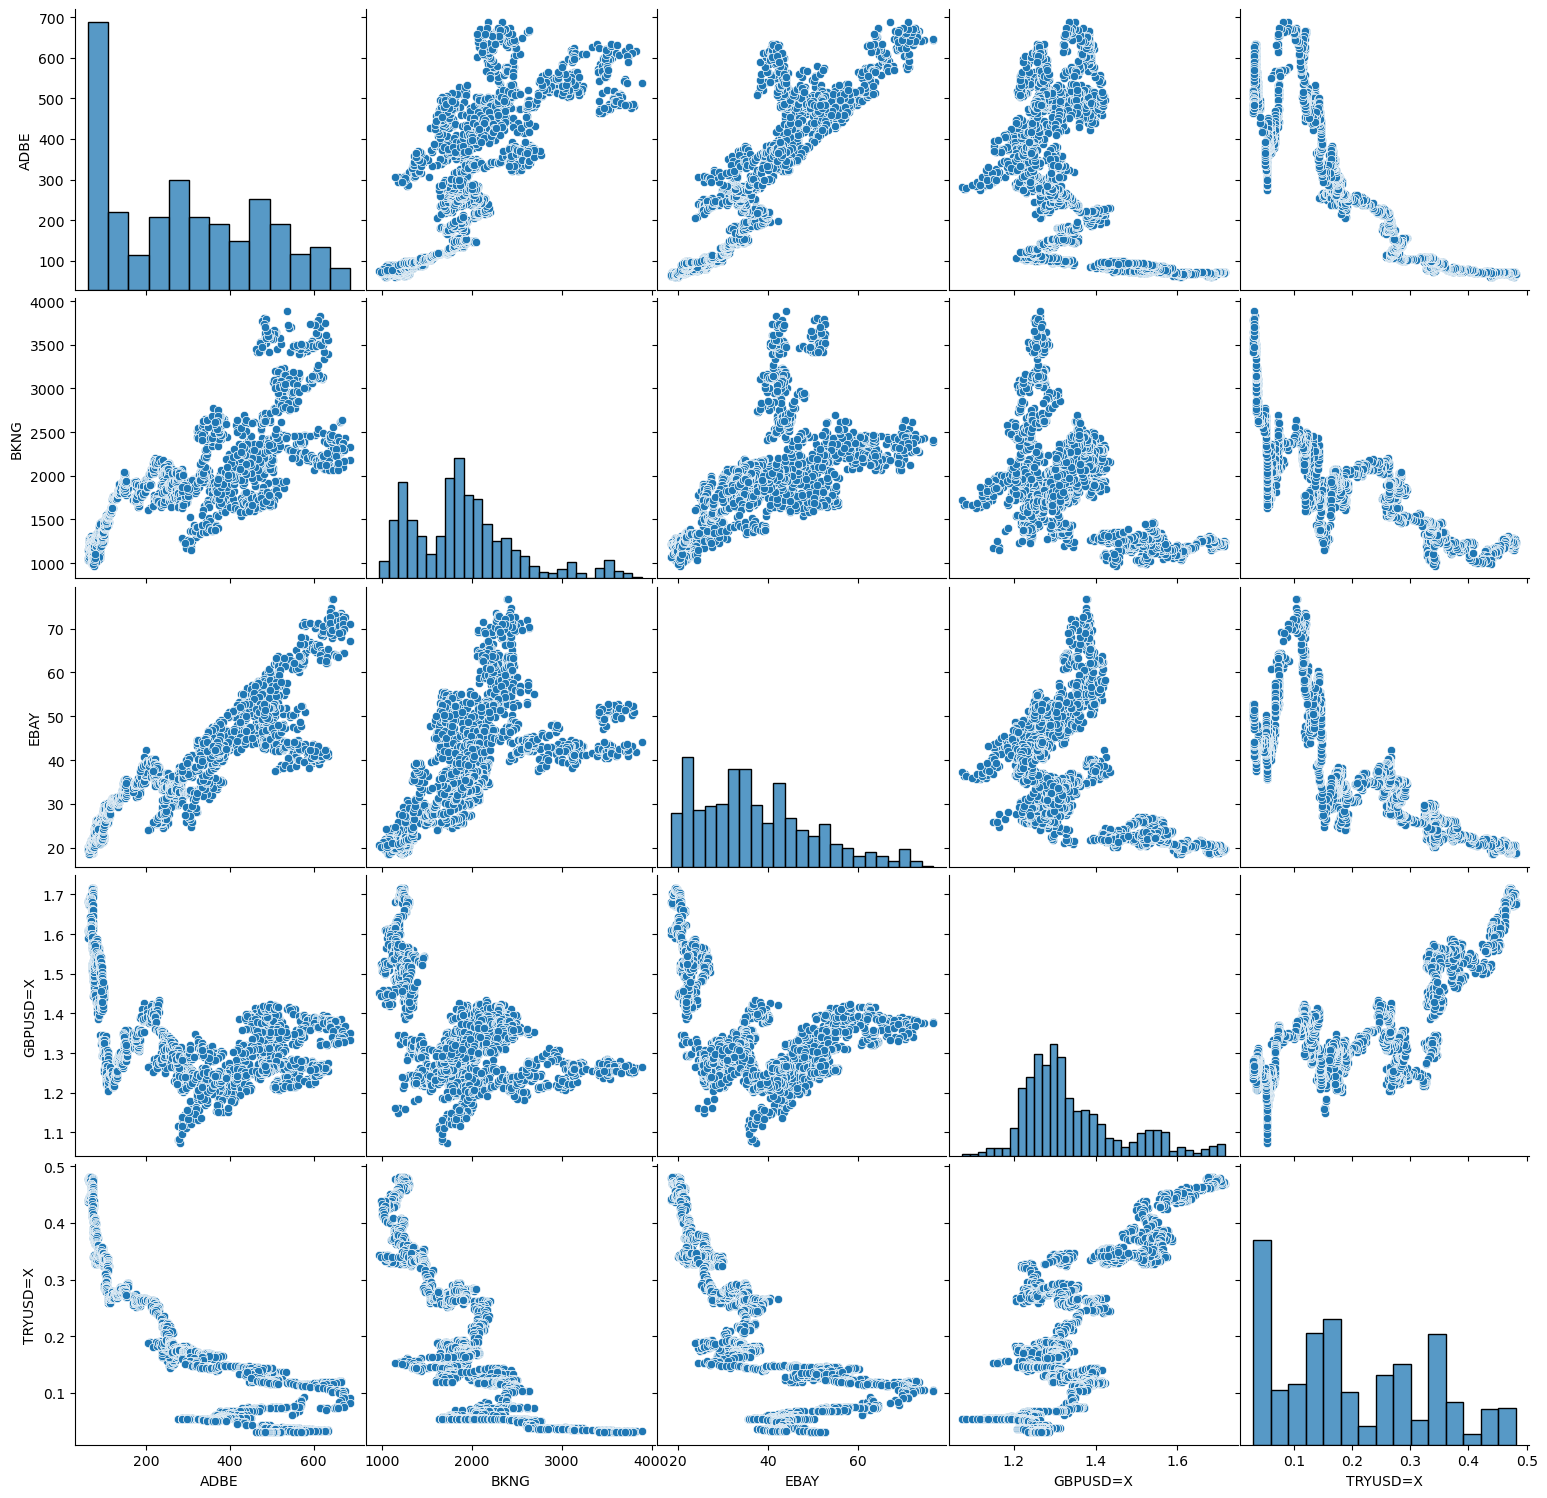

In [312]:
pair_plot = sns.pairplot(prices, kind='scatter', height=5, aspect=3)
pair_plot.fig.set_size_inches(15, 15)
plt.show()

<Figure size 700x700 with 0 Axes>

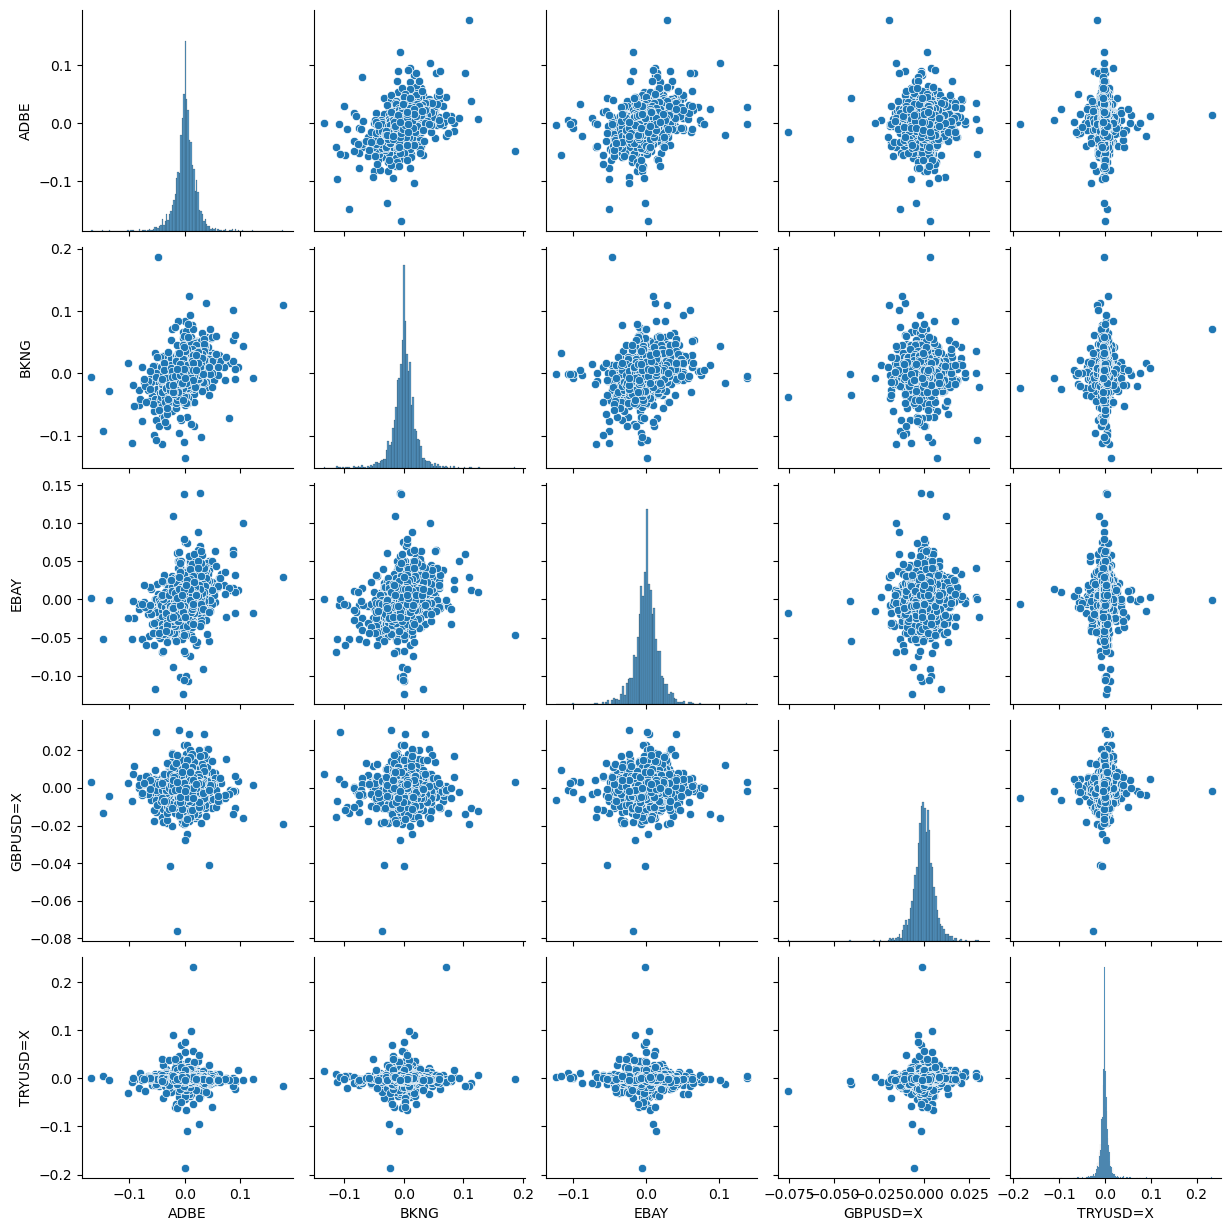

In [313]:
fig = plt.figure(figsize=(7, 7))
sns.pairplot(returns)
plt.show(); 

Зависимость не наблюдается между парами лиры с чем-нибудь (ось ординат): большая часть точек на графиках вырисовывает линию параллельную оси абсцисс - и фунт стерлингов тоже выглядит как хаотичное облако. На остальных графиках  сложно разглядеть зависимость, разве что между Букингом и Ебаем можно увидеть какую-то зависимость и прочертить мысленно график линейной функции с наклоном (можно подумать, что это из-за того что они оба - интернет-сервисы, если сильно притянуть, то их успешность зависит от интернет-пользователей). Между Адобом и Букингом также вырисовывается заивисимость линейная.

#### 2.2 (1 балл)
Изобразите гистограмму распределения каждого инструмента, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

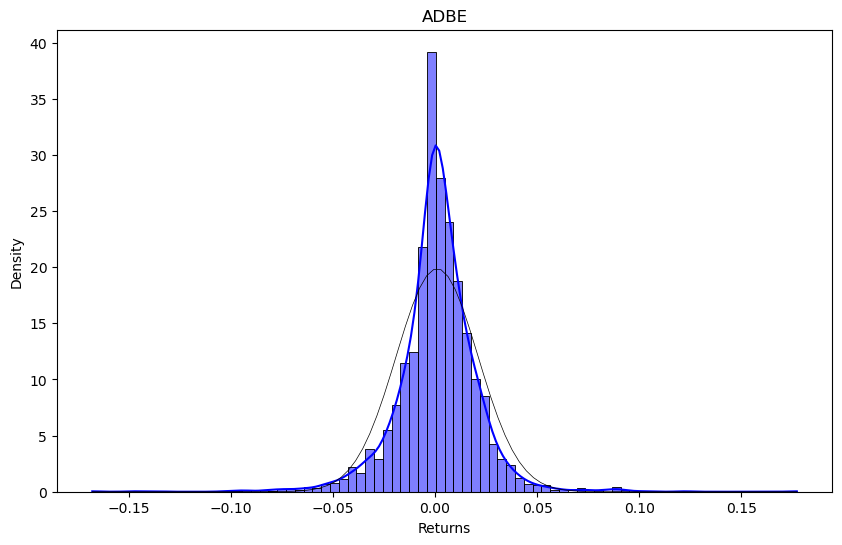

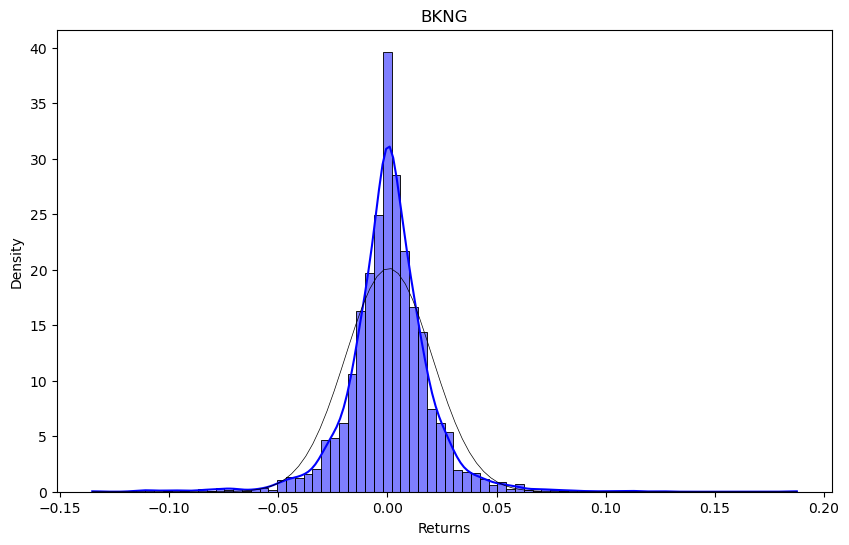

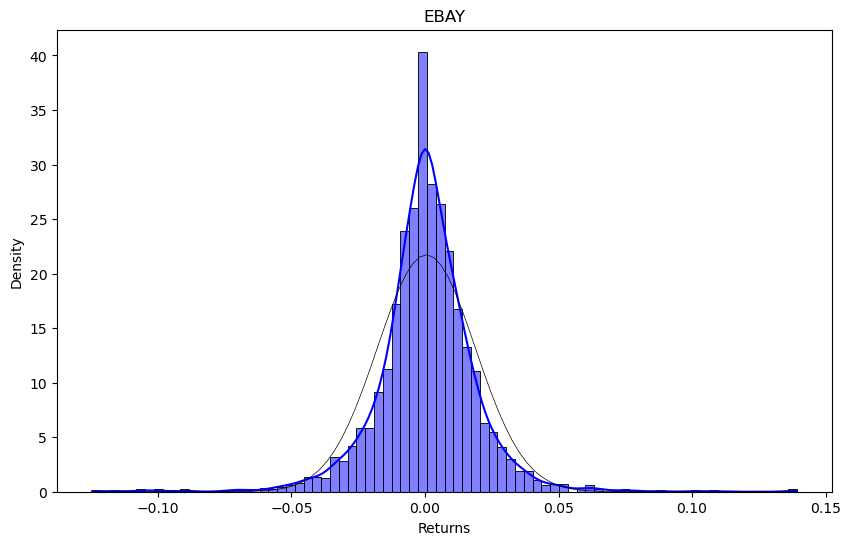

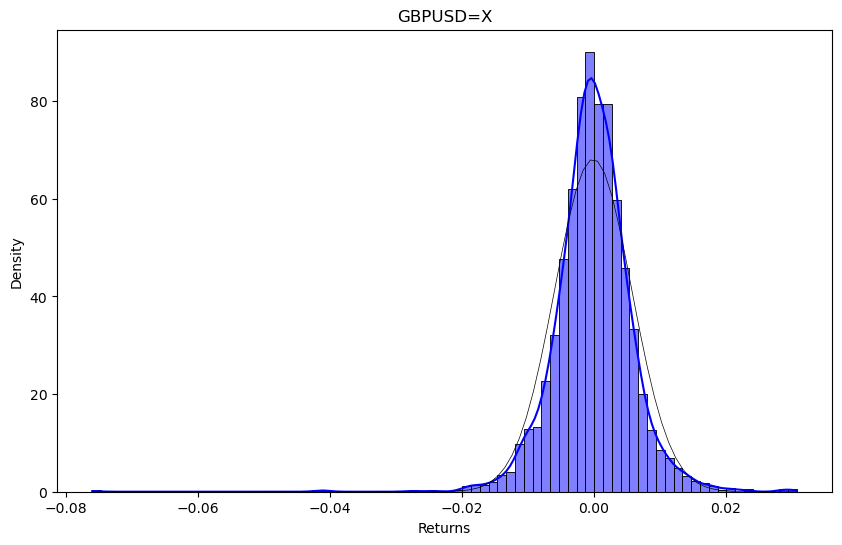

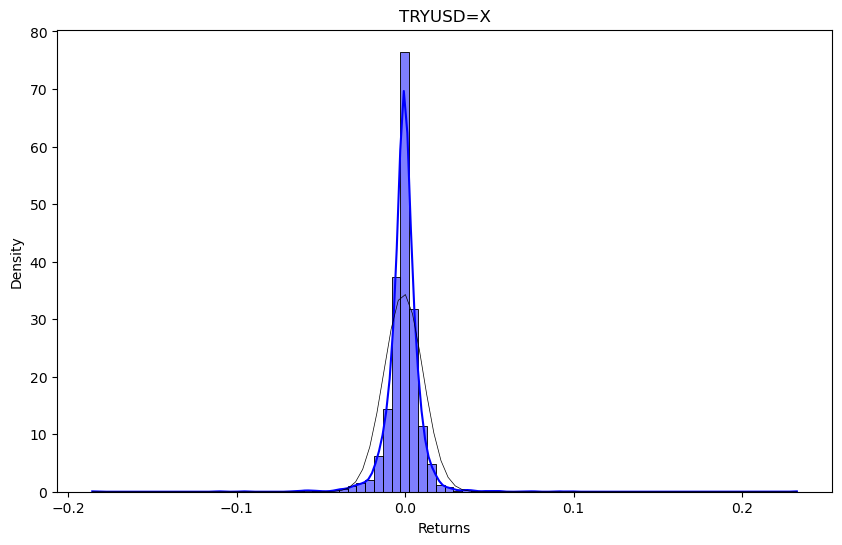

In [314]:
for column in returns.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(returns[column], kde=True, stat='density', bins=80, color='blue', edgecolor='black')
    mean, std = norm.fit(returns[column])
    
    x = np.linspace(returns[column].min(), returns[column].max(), 100)
    p = norm.pdf(x, mean, std)    
    plt.plot(x, p, 'k', linewidth=0.5)
    title = f'{column}' 
    plt.title(title)
    plt.xlabel('Returns')
    plt.ylabel('Density')
    
    plt.show()

In [315]:
for column in returns.columns:
    mean = returns[column].mean()
    disp = returns[column].var()
    print(f'Для {column} среднее: {mean:.10f}, а дисперсия: {disp:.10f}')

Для ADBE среднее: 0.0009891216, а дисперсия: 0.0004036937
Для BKNG среднее: 0.0006438441, а дисперсия: 0.0003933501
Для EBAY среднее: 0.0005280110, а дисперсия: 0.0003373447
Для GBPUSD=X среднее: -0.0000914238, а дисперсия: 0.0000342867
Для TRYUSD=X среднее: -0.0009803881, а дисперсия: 0.0001341677


У всех акций в среднем небольшая, но положительная доходность с небольшой дисперсией. В среднем доходность валюты снижалась, причем у лиры на порядок больше, чем у фунта стерлингов. Дисперсия у последнего также выше лиры, но все еще достаточно умеренная.

#### 2.3 (0.5 балла)
В качестве весов портфеля используйте веса на момент покупки (как в семинаре). Изобразите  гистограмму распределения доходностей портфеля, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

Let's consider a case of equally-weighted portfolio with weights wi=1/pi. This way, price changes of all companies will have the same level of contribution in a change of a portfolio

In [316]:
w_temp = 1 / prices[tickers].iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns[tickers].values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)
(w_temp)

Ticker
BKNG        0.000314
EBAY        0.017973
ADBE        0.005831
TRYUSD=X    0.760317
GBPUSD=X    0.215565
Name: 2014-05-19 00:00:00, dtype: float64

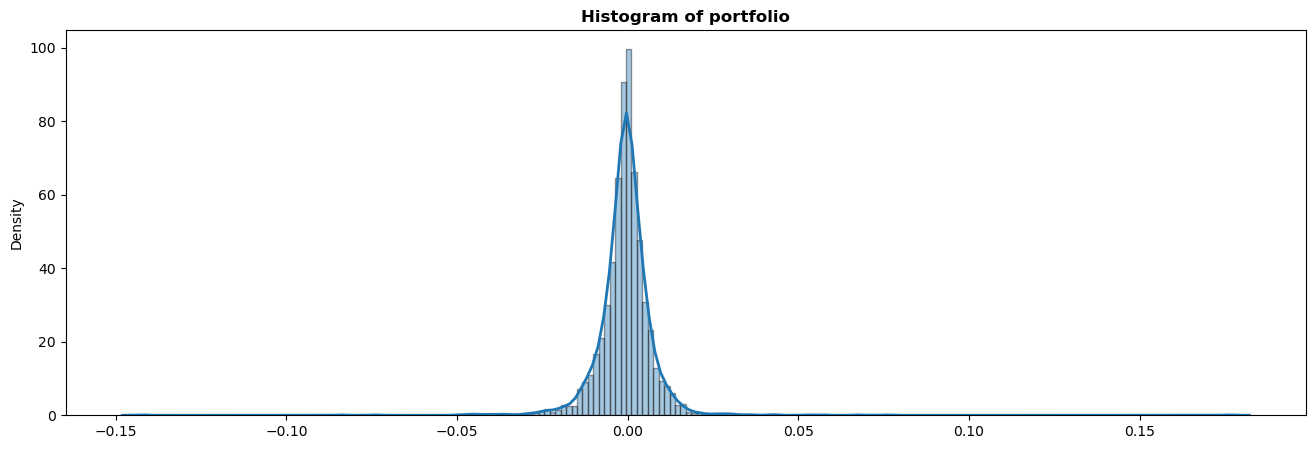

Доходность изначального портфеля - среднее: -0.0007, дисперсия: 0.0001


In [317]:
fig = plt.figure(figsize=(16, 5))
sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=200,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2
                })
plt.title("Histogram of portfolio", weight="bold")
plt.show()
mean = portfolio_real_returns_selected.mean()
var = portfolio_real_returns_selected.var()
print(f'Доходность изначального портфеля - среднее: {mean:.4f}, дисперсия: {var:.4f}')

Изначальный портфель в среднем приносит нам убытки, что логично, так как в нем 97% составляет валюта, а выше мы видели, что в среднем доходность за 10 лет у обеих валют снижалась, но зато волатильность портфеля невысока.


#### 2.4 (0.5 балла)
Придумайте, опишите и примените альтернативную стратегию взвешивания. Поясните, почему она имеет смысл.

In [318]:
volatility = returns[tickers].std()
w_volatility = 1 / volatility
w_volatility = w_volatility / w_volatility.sum()
portfolio_returns_volatility = np.dot(returns[tickers].values, w_volatility)
portfolio_returns_volatility = pd.Series(portfolio_returns_volatility, index=returns.index)
w_volatility

Ticker
BKNG        0.122455
EBAY        0.132230
ADBE        0.120876
TRYUSD=X    0.209673
GBPUSD=X    0.414766
dtype: float64

Изучив числа по дисперсиям активов выше, пришла идея взвесить их по степени волатильности: чем она меньше, тем больше вес актива в портфеле, так как можно считать такие активы менее рисковыми и более стабильными, да и диверсификация портфеля все-таки! Тем не менее, валюты все равно занимают бОльшую часть портфеля, а еще мы лишаем себя потенциальной допдоходности, которая могла бы прийти с высоковолатильными активами.

### 3. Анализ отдельных инструментов. (2 балла, по 0.4 за инструмент)

* Подберите для каждого инструмента наиболее подходящее маржинальное распределение. Можно использовать всё, что есть в scipy, а также garch-модель.
* Для каждого результата изобразите калибровочную кривую (qq-plot), а также наложите оценённую функцию плотности на гистограмму распределения доходности. Прокомментируйте графики.

Обратите внимание, что для GARCH-модели подход будет особенный в плане построения qq-plot и гистограммы. Как мы помним из формулы ниже, дисперсия у нас представлена умножением условной волатильности на распределение. Поэтому на qq-plot и гистограмме нужно будет визуализировать стандартизированные остатки против функции плотности $\epsilon$.

$$r_{t+1} = \mu_t  + \sqrt{h_t}\epsilon_t \text{  with  } \epsilon_t \sim N(0, 1)$$


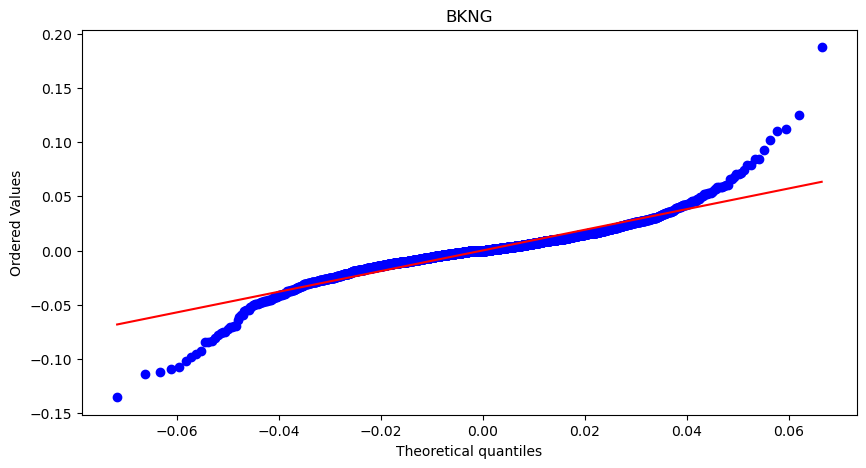

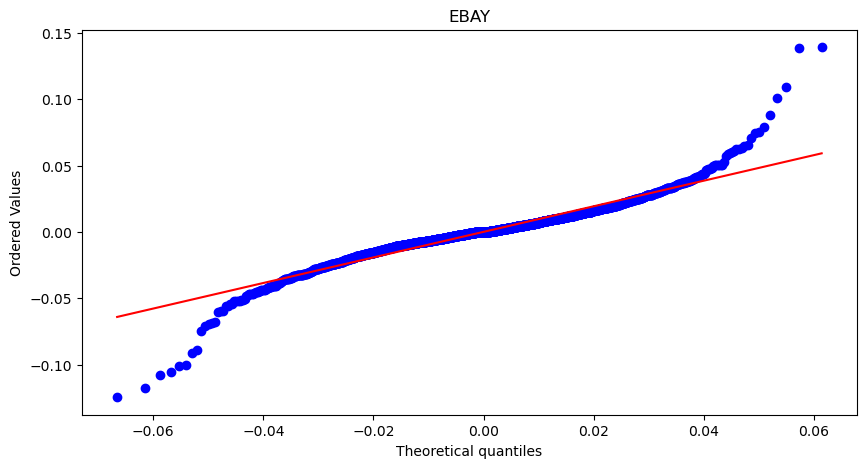

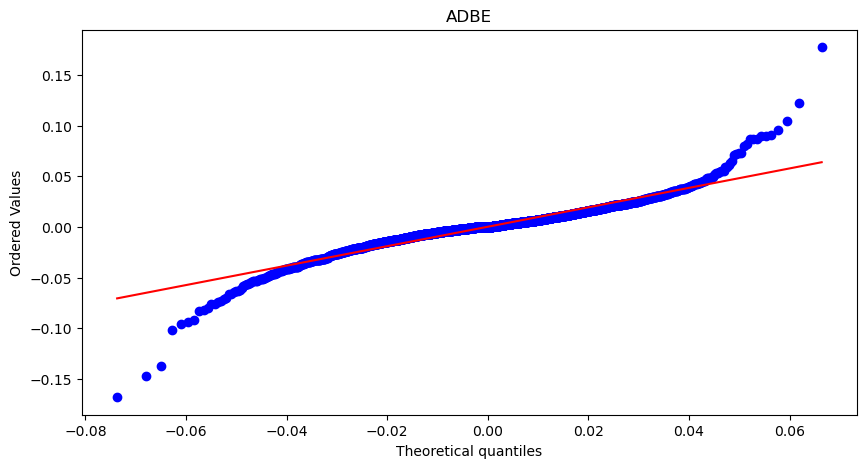

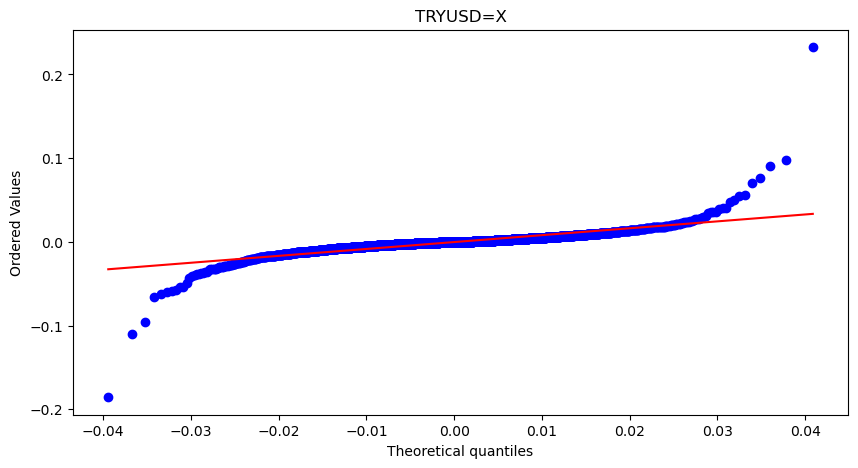

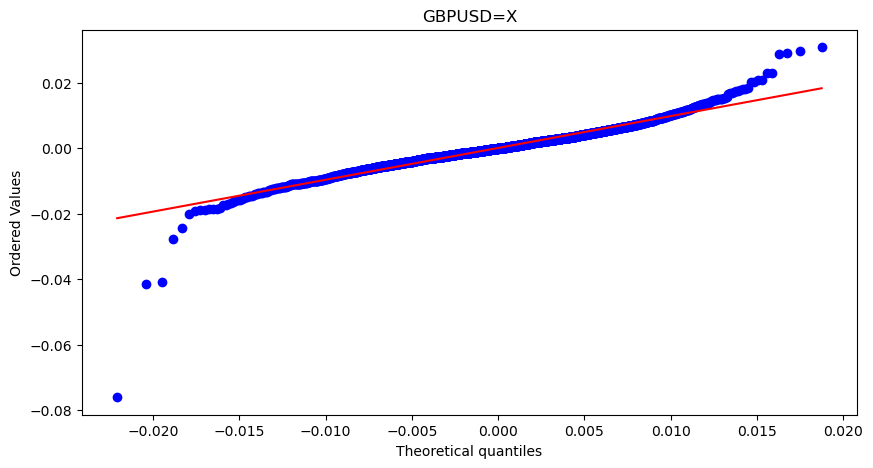

In [319]:
for i, ticker in enumerate(tickers):
    skew_norm = ss.skewnorm.fit(returns[ticker])
    fig = plt.figure(figsize=(10, 5))

    ss.probplot(returns[ticker], dist=ss.skewnorm(*skew_norm), plot=plt)
    plt.title(ticker) 
    plt.show()

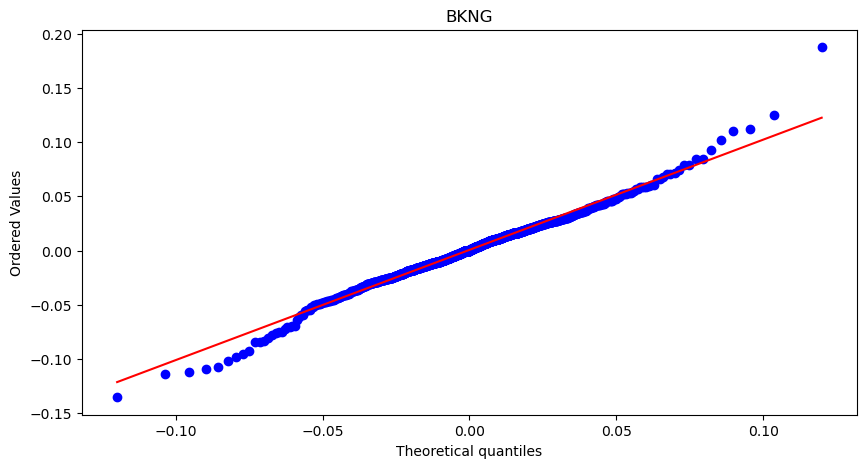

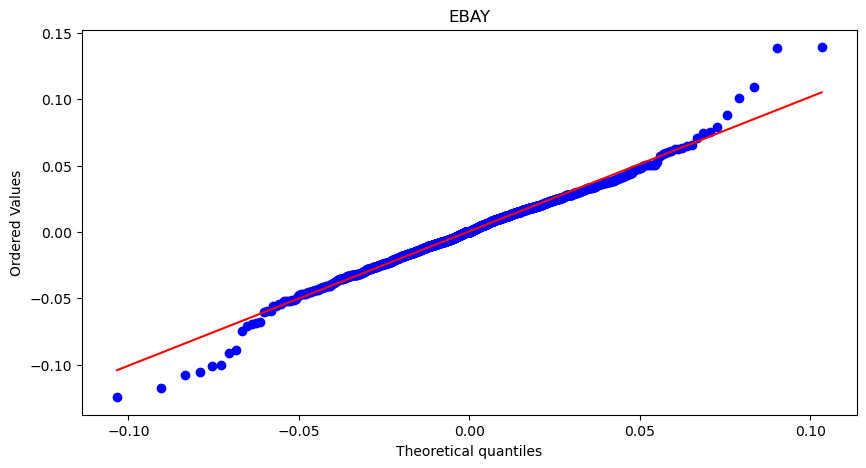

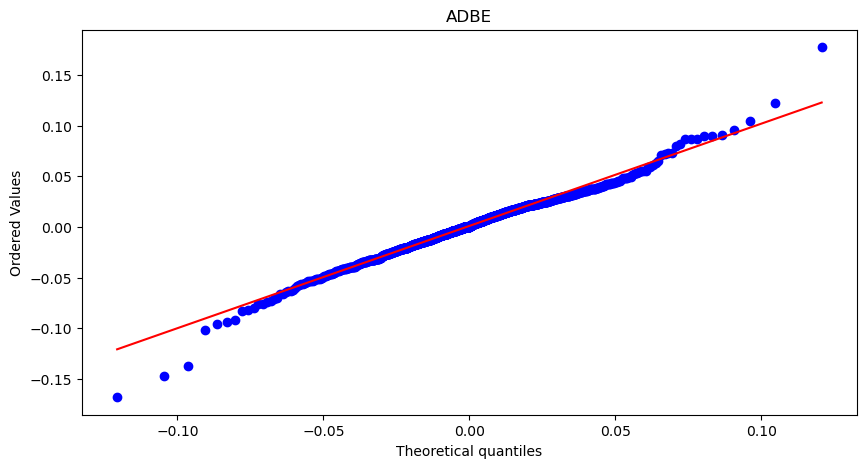

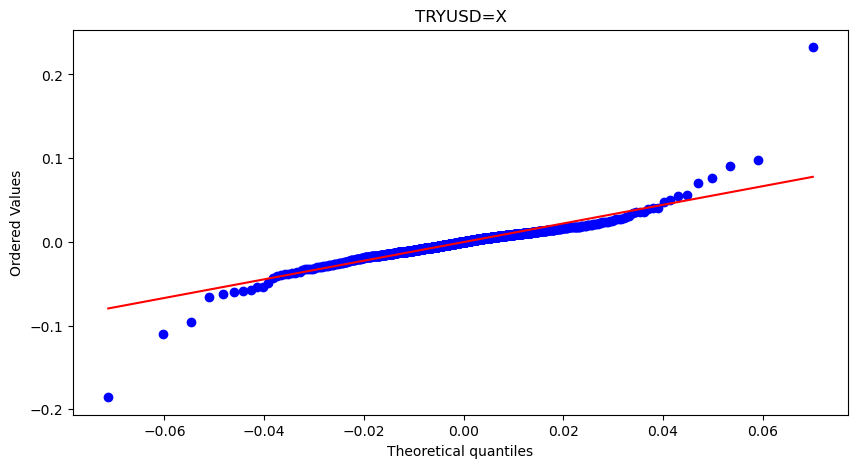

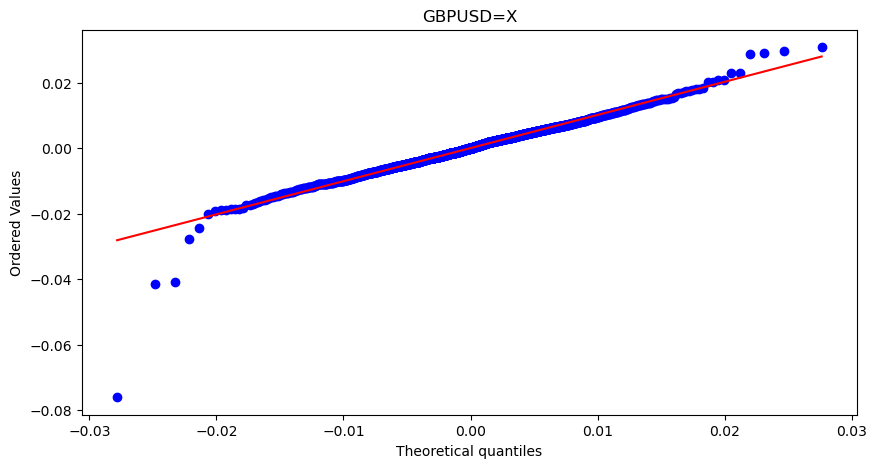

In [250]:
for i, ticker in enumerate(tickers): 
    params_gennorm = ss.gennorm.fit(returns[ticker])
    fig = plt.figure(figsize=(10, 5))
    ss.probplot(returns[ticker], dist=ss.gennorm(*params_gennorm), plot=plt)
    plt.title(ticker)    
    plt.show()

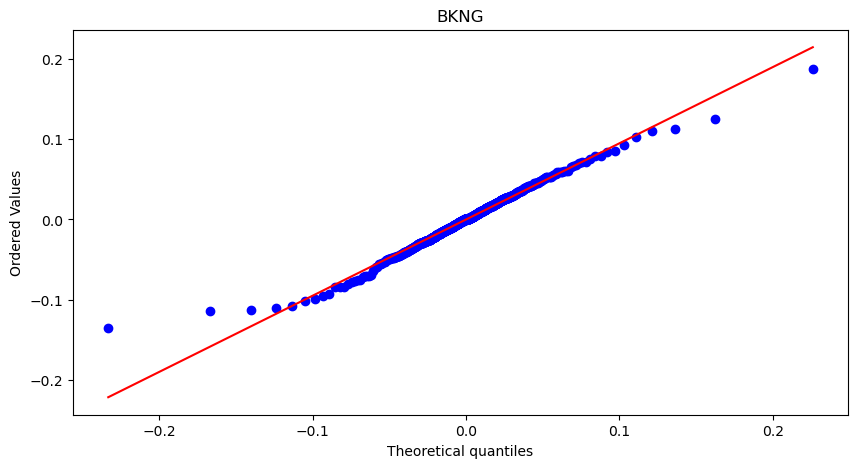

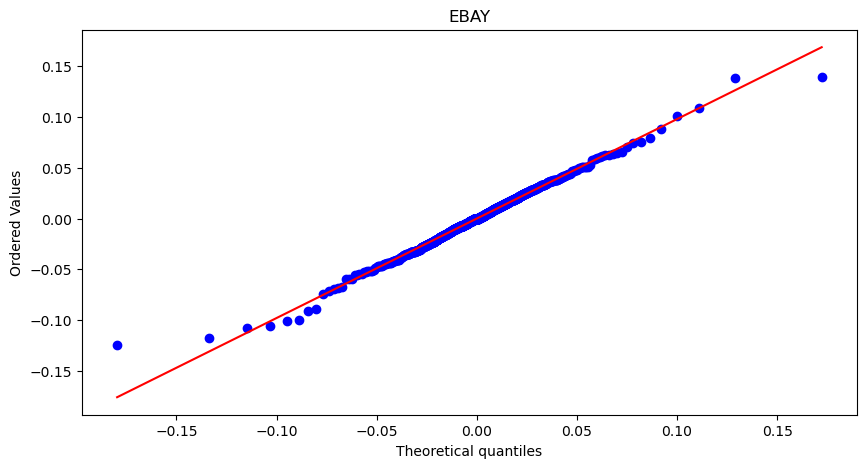

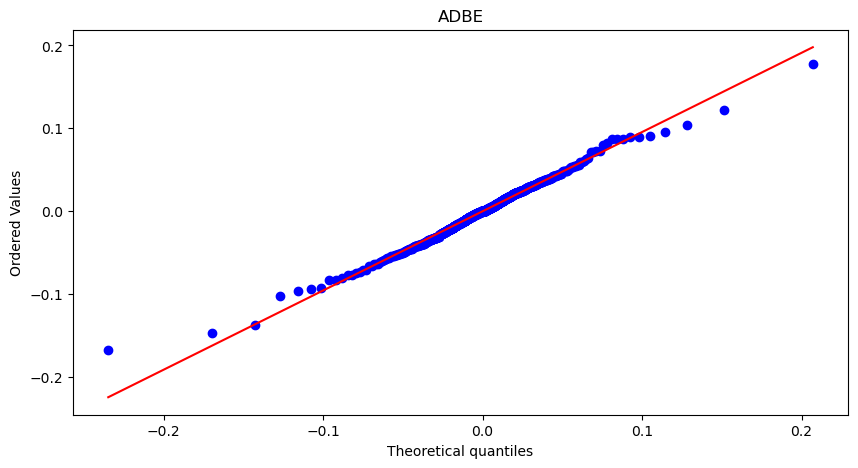

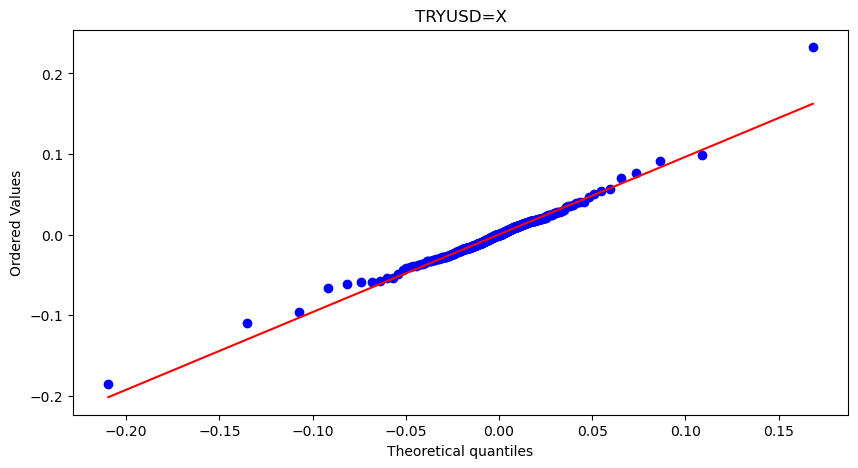

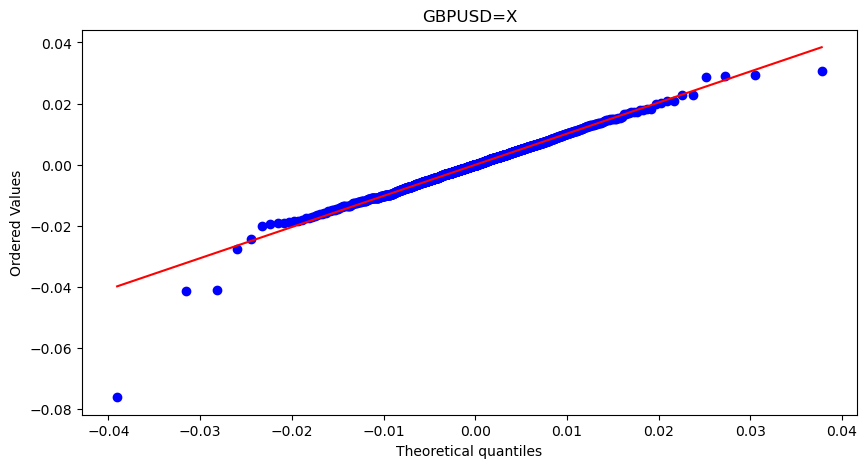

In [320]:
for i, ticker in enumerate(tickers):
    params_nct = ss.nct.fit(returns[ticker])
    fig = plt.figure(figsize=(10, 5))
    ss.probplot(returns[ticker], dist=ss.nct(*params_nct), plot=plt)
    plt.title(ticker)    
    plt.show()

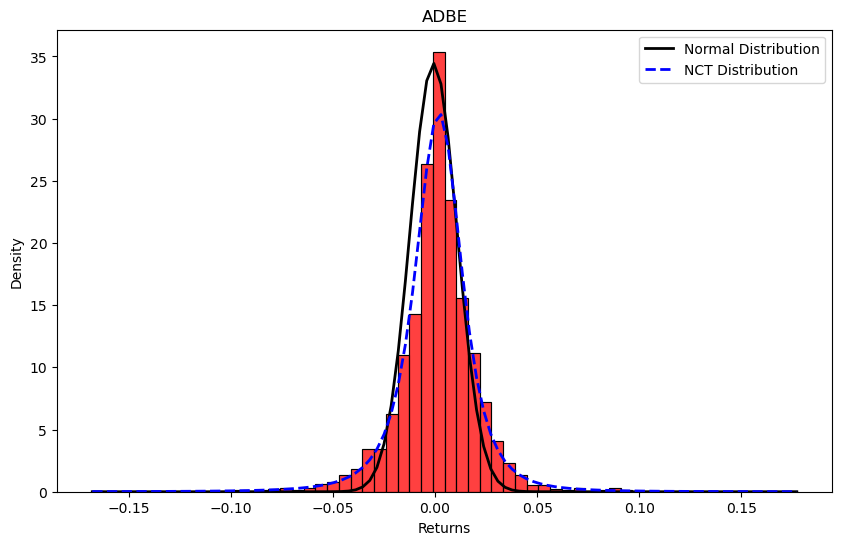

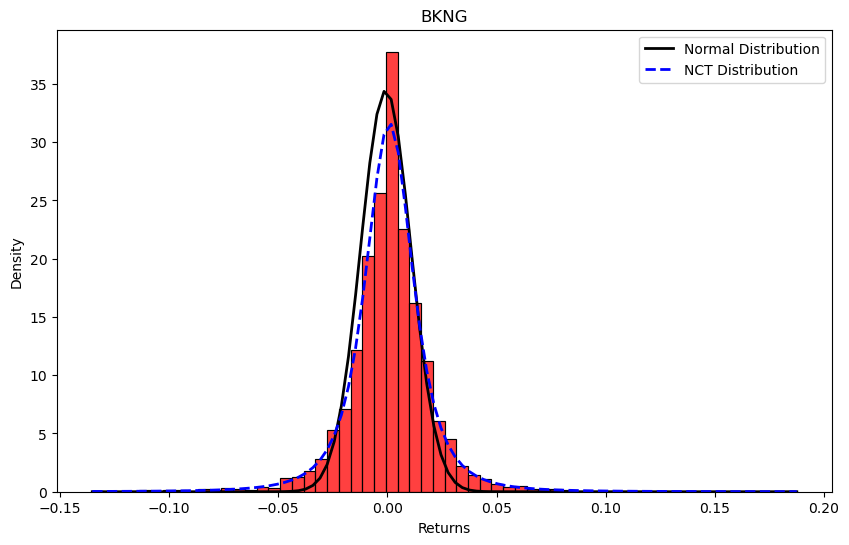

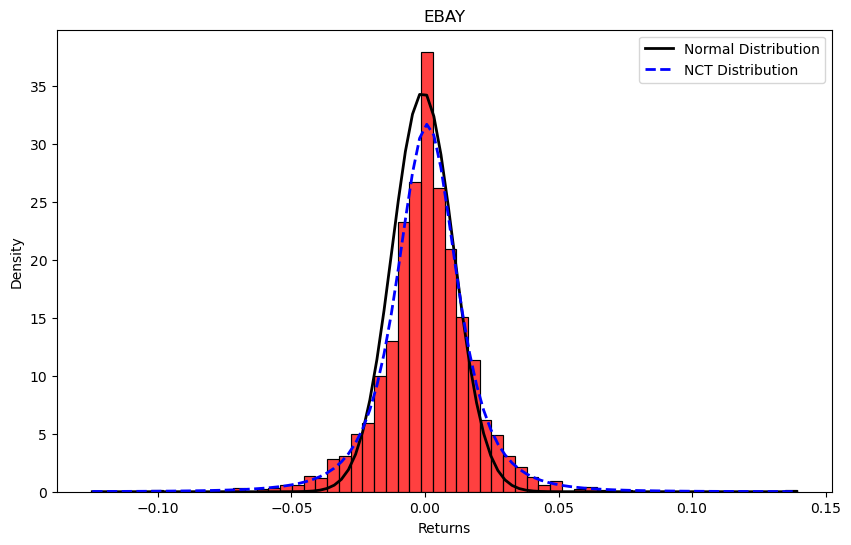

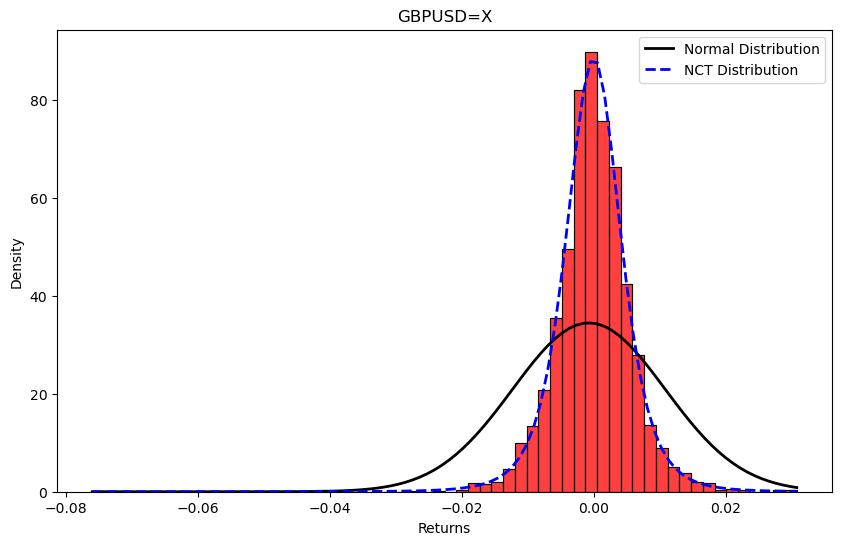

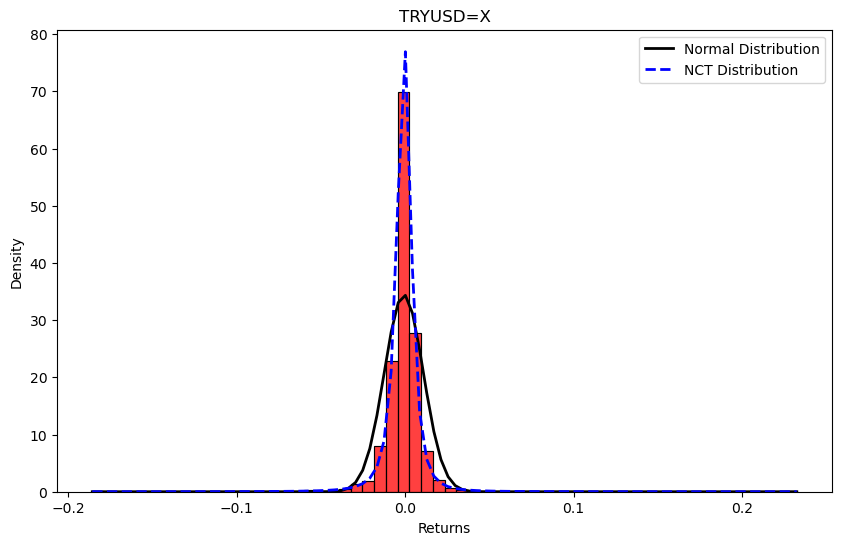

In [321]:
#я прошерстила весь скайпай.статс и нарисовала все распределения, 
# по-моему лучше всего на q-q plots выглядит nct распределение (A non-central Student’s t continuous random variable.)
for column in returns.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(returns[column], kde=False, stat='density', bins=60, color='red', edgecolor='black')   

    x = np.linspace(returns[column].min(), returns[column].max(), 100)
    p = ss.norm.pdf(x, mean, std)   
    plt.plot(x, p, 'k', linewidth=2)
    title = f'{column}'
    plt.title(title)
    plt.xlabel('Returns')
    plt.ylabel('Density')
    params_nct = ss.nct.fit(returns[column])
    p_nct = ss.nct.pdf(x, *params_nct)   
    plt.plot(x, p_nct, 'b--', linewidth=2)    
    plt.legend(['Normal Distribution', 'NCT Distribution'])  
    plt.show()

На всех графиках NCT Distibution выглядит лучше обычного нормального распределения, идеально подобрать не получилось.

### 4) Копулы
Мы знаем, что по-отдельности инструменты моделируются довольно легко. Однако так как мы рассматриваем портфель, акции и валюты могут быть скоррелированы. Особенно в случае, когда ваши акции взяты из похожих компаний. Поэтому нам бы хотелось иметь метод, который хорошо учитывает такие зависимости в совокупности. Копулы -- один из таких способов. Ваша последовательность действий будет выглядеть следующим образом:

Пусть мы имеем историю доходностей 5 инструментов за предыдущие 10 лет (условно 365*10 = 3650 наблюдений). Пусть мы хотим сделать прогноз VaR на один шаг вперёд. Представим данные в виде таблицы $3650\times5$

1. Используем найденные в предыдущем пункте распределения. Для каждого из инструментов прогоним доходности через фукнцию распределения. Для GARCH нужно будет предварительно получить стандартизированные остатки, так как распределение оценивается именно для них. Получим вектор той же длины, но уже в диапазоне [0, 1]. Получим таблицу аналогичной размерности, $3650\times5$. По сути, мы переходим в новое признаковое пространство, в котором нам легко оценить и просимулировать распределение с очень сложными зависимостями.

2. Оценим на этой матрице копулу. Выберем наилучшую копулу по AIC.

3. Произведём симуляции из копулы. Так как копула будет иметь размерность 5, то выходная матрица симуляций будет иметь размер $n\_sim\times5$. Ожидается, что компоненты этой симуляции будут коррелированы соответственно исходным данным.

4. Для каждого из пяти инструментов в симуляции проведём обратное преобразование. Для этого используем обратную функцию распределения. Для GARCH нужно будет дополнительно использовать прогнозы матожидания и дисперсии. Получим всё также матрицу $n\_sim\times5$.

5. Далее для подсчёта VaR можно просто взвесить доходности отдельных компонент обратно в портфель и взять от этого квантиль. Для подсчёта ES можно взять математичечкое ожидание доходностей портфеля, которые меньше VaR. Используйте 5%-й VaR.

Используйте одну копулу. Для простоты давайте ограничимся [Архимедовыми копулами](https://copulae.readthedocs.io/en/latest/api_reference/copulae/archimedean/index.html). Они имеют минимум параметров и быстро оцениваются. Не пытайтесь выполнить это задание с эллиптическими копулами (гауссова, стьюдента). Они оцениваются очень долго и вы устанете считать.

Начнём с простого и будем работать со всеми данными сразу. 


#### 4.1 (1 балл)
Проведите преобразование, переводящее доходности на единичный куб. Воспользуйтесь функциями распределения из пункта 4. Опять же, обратите внимание, что GARCH необходимо обрабатывать отдельно и работать с распределением стандартизированных остатков.

In [322]:
uniform_returns = pd.DataFrame(index=returns.index)
nct_params = {}
for ticker in tickers:
    params_nct = ss.nct.fit(returns[ticker])
    nct_params[ticker] = params_nct
    cdf_values = ss.nct.cdf(returns[ticker], *params_nct)
    uniform_returns[ticker] = cdf_values
uniform_returns.head()

,BKNG,EBAY,ADBE,TRYUSD=X,GBPUSD=X
Date,,,,,
2014-05-20,0.268284,0.276020,0.251091,0.603086,0.465803
2014-05-21,0.925111,0.429458,0.785033,0.134494,0.609925
2014-05-22,0.490908,0.270008,0.756079,0.923299,0.779921
2014-05-23,0.859577,0.762753,0.873271,0.858099,0.354150
2014-05-26,0.474283,0.477573,0.454882,0.622278,0.337109


#### 4.2 (1 балл) 

Используйте пакет [copulae](https://pypi.org/project/copulae/). Подберите по AIC Архимедовы копулы. Выберите одну из двух опций:
1. Выберите лучшую копулу на всех доходностях.  (0.5 балла)
2. Выберите две отдельные копулы. Одна на валюты, одна на акции. (1 балл)


In [323]:
from copulae.archimedean import ClaytonCopula, FrankCopula, GumbelCopula

stocks = uniform_returns[['BKNG', 'EBAY', 'ADBE']]
curr = uniform_returns[['TRYUSD=X', 'GBPUSD=X']]

def compute_aic(log_likelihood, num_params):
    return -2 * log_likelihood + 2 * num_params

def fit_copula_and_get_aic(data, copula_type):
    copula = copula_type(dim=data.shape[1])
    copula.fit(data.values)
    log_likelihood = copula.log_lik(data.values)
    num_params = 1
    aic = compute_aic(log_likelihood, num_params)
    return copula, aic

def best_copula(data, copula_types):
    best_aic = np.inf
    best_copula = None
    for copula_type in copula_types:
        copula, aic_value = fit_copula_and_get_aic(data, copula_type)
        if aic_value < best_aic:
            best_aic = aic_value
            best_copula = copula
    return best_copula, best_aic

copula_to_choose = [FrankCopula, ClaytonCopula, GumbelCopula]

best_copula_all, best_aic_all = best_copula(uniform_returns, copula_to_choose)
print(f"Лучший AIC для всех доходностей: {best_aic_all}, Копула: {type(best_copula_all)}")

best_copula_stocks, best_aic_stocks = best_copula(stocks, copula_to_choose)
print(f"Лучший AIC для акций: {best_aic_stocks}, Копула: {type(best_copula_stocks)}")

best_copula_currencies, best_aic_currencies = best_copula(curr, copula_to_choose)
print(f"Лучший AIC для валют: {best_aic_currencies}, Копула: {type(best_copula_currencies)}")


Лучший AIC для всех доходностей: -523.4662613043186, Копула: <class 'copulae.archimedean.clayton.ClaytonCopula'>
Лучший AIC для акций: -1162.338507672181, Копула: <class 'copulae.archimedean.frank.FrankCopula'>
Лучший AIC для валют: -109.46144166733703, Копула: <class 'copulae.archimedean.frank.FrankCopula'>


#### 4.3 (1 балл)
Просимулируйте с помощью копулы ваши инструменты. Для любой пары инструментов нарисуйте четыре scatter-plot в ряд:

1. Исходные доходности
2. Доходности, переведённые на единичный куб
3. Просимулированные доходности на единичном кубе
4. Просимулированные доходности, переведённые в исходные величины

Графики 1/4 и 2/3 должны иметь примерно одинаковые зависимости.

In [324]:
def simulator(copula, n_samples, dim):
    return copula.random(n_samples)

n_samples = len(returns)
sim_uniform_all = simulator(best_copula_all, n_samples, uniform_returns.shape[1])
sim_uniform_stocks = simulator(best_copula_stocks, n_samples, stocks.shape[1])
sim_uniform_curr = simulator(best_copula_currencies, n_samples, curr.shape[1])

def inv_trans(simulated_uniform, original_returns, nct_params):
    simulated_returns = pd.DataFrame(index=original_returns.index, columns=original_returns.columns)
    for i, ticker in enumerate(original_returns.columns):
        params_nct = nct_params[ticker]
        simulated_returns[ticker] = ss.nct.ppf(simulated_uniform[:, i], *params_nct)
    return simulated_returns

sim_returns_all = inv_trans(sim_uniform_all, returns, nct_params)
sim_returns_stocks = inv_trans(sim_uniform_stocks, stocks, nct_params)
sim_returns_curr = inv_trans(sim_uniform_curr, curr, nct_params)

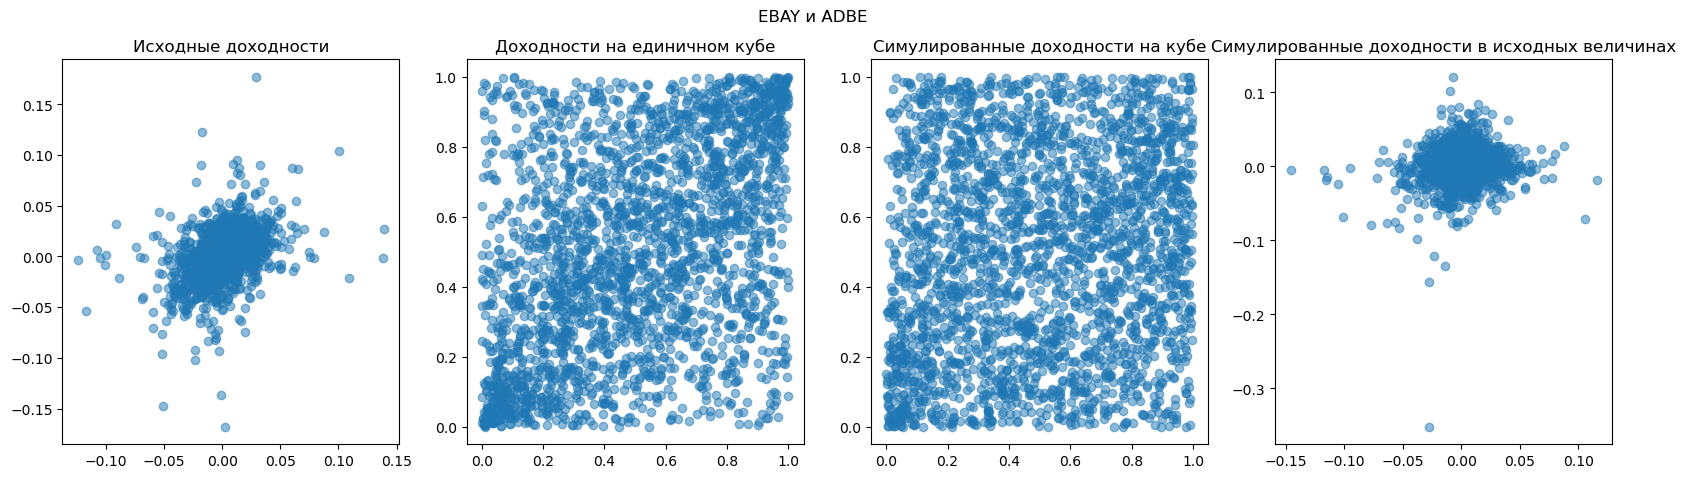

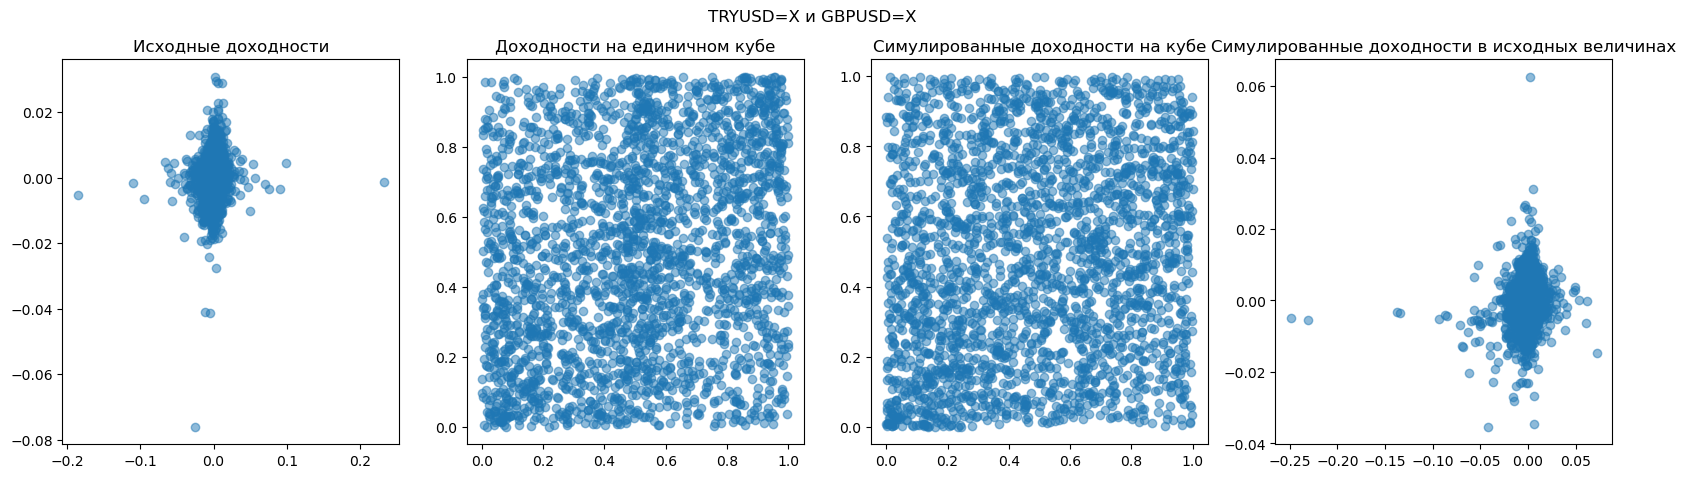

In [325]:
def plot_scatter(data_dict, title):
    fig, axes = plt.subplots(1, len(data_dict), figsize=(5 * len(data_dict), 5))
    
    for ax, (plot_title, data) in zip(axes, data_dict.items()):
        ax.scatter(data[:, 0], data[:, 1], alpha=0.5)
        ax.set_title(plot_title)
    
    fig.suptitle(title)
    plt.show()

data_sets_ebay_adbe = {
    'Исходные доходности': returns[['EBAY', 'ADBE']].values,
    'Доходности на единичном кубе': uniform_returns[['EBAY', 'ADBE']].values,
    'Симулированные доходности на кубе': sim_uniform_all[:, [0, 1]],
    'Симулированные доходности в исходных величинах': sim_returns_all[['EBAY', 'ADBE']].values
}

plot_scatter(data_sets_ebay_adbe, 'EBAY и ADBE')

data_sets_tryusd_gbpusd = {
    'Исходные доходности': returns[['TRYUSD=X', 'GBPUSD=X']].values,
    'Доходности на единичном кубе': uniform_returns[['TRYUSD=X', 'GBPUSD=X']].values,
    'Симулированные доходности на кубе': sim_uniform_all[:, [3, 4]],
    'Симулированные доходности в исходных величинах': sim_returns_all[['TRYUSD=X', 'GBPUSD=X']].values
}

plot_scatter(data_sets_tryusd_gbpusd, 'TRYUSD=X и GBPUSD=X')
# ну вроде похоже)))))

### 5) VaR и ES (1 балл)

С помощью выбранных распределений и копул вычислите VaR-кривую и ES-кривую. Можно ориентироваться на функцию с семинара 12. Модифицируйте её для подсчёта ES. Если вы использовали альтернативную стратегию взвешивания, также учтите это.

In [327]:
def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    ES = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)
            
            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            ES[i] = portfolio_simulated_returns[portfolio_simulated_returns <= VaR[i]].mean()
            
        except Exception as e:
            print(f"Error at index {i}: {e}")
            VaR[i] = VaR[i-1]
            ES[i] = ES[i-1]
        
    return pd.Series(data=VaR, index=r.index, name='VaR'), pd.Series(data=ES, index=r.index, name='ES')

var, es = calc_VaR(returns, lambda x: inv_trans(simulator(best_copula_all, len(x), x.shape[1]), x, nct_params), w_volatility)
print(var)
print(es)

Date
2014-05-20         NaN
2014-05-21         NaN
2014-05-22         NaN
2014-05-23         NaN
2014-05-26         NaN
                ...   
2024-05-13   -0.013386
2024-05-14   -0.013267
2024-05-15   -0.010221
2024-05-16   -0.009666
2024-05-17   -0.010872
Freq: B, Name: VaR, Length: 2609, dtype: float64
Date
2014-05-20         NaN
2014-05-21         NaN
2014-05-22         NaN
2014-05-23         NaN
2014-05-26         NaN
                ...   
2024-05-13   -0.023527
2024-05-14   -0.029861
2024-05-15   -0.015187
2024-05-16   -0.013767
2024-05-17   -0.023962
Freq: B, Name: ES, Length: 2609, dtype: float64


### 6) Визуализация (0.5 балла)

Визуализируйте VaR и ES на графике с доходностями.

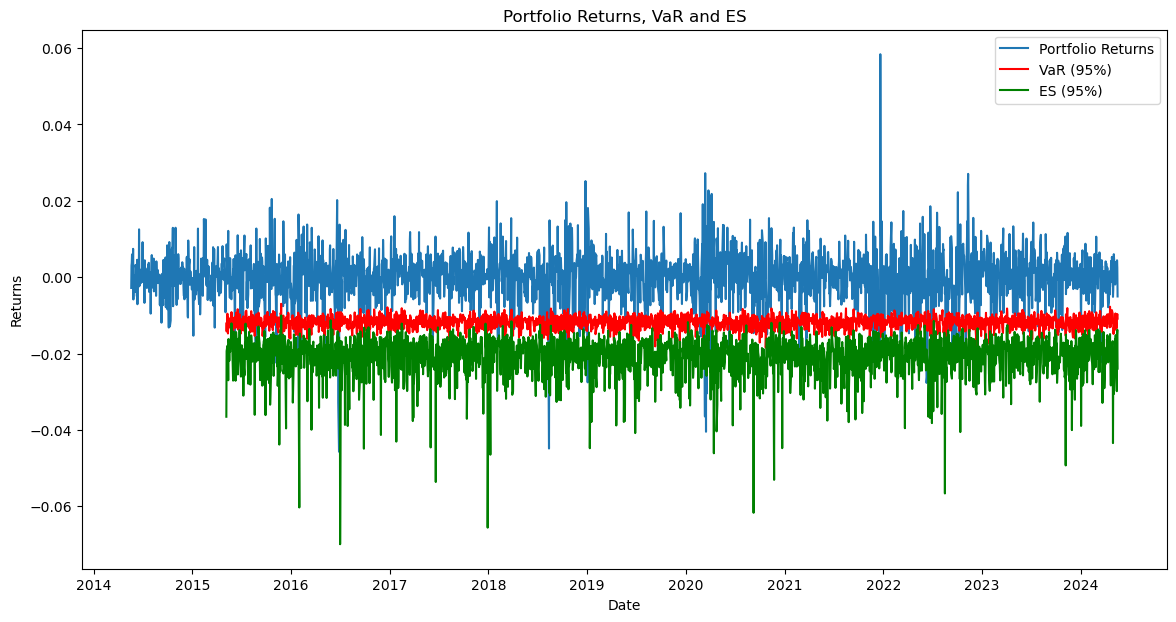

In [328]:
plt.figure(figsize=(14, 7))
plt.plot(portfolio_returns_volatility.index, portfolio_returns_volatility, label='Portfolio Returns')
plt.plot(var.index, var, label='VaR (95%)', color='r')
plt.plot(es.index, es, label='ES (95%)', color='g')
plt.title('Portfolio Returns, VaR and ES')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

### 7) Бектестинг. (1 балл)

Проведите тесты на покрытие и независимость для VAR-кривой. Добейтесь того, чтобы тесты успешно проходились, без этого пункт не засчитывается. Если потребуется, вернитесь к подбору частных распределений.

In [329]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))

def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))
    
def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')
        

In [330]:
backtest_results(portfolio_returns_volatility, var, alpha=0.05) #не получилось независимость пройти)

Target share of violations: 5.00%
Observed share of violations: 4.84%

Test for coverage is passed

Test for independence isn't passed


##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7 **я прошла**